#### Torch CNN - CIFAR10

In [1]:
import PIL
import torch
import torchvision
import torch.nn as nn
import torchvision.transforms as transforms
from models import CNN

BATCH_SIZE = 128
DOWNLOAD = False
SUBSET = 0

train_transform = transforms.Compose(
    [transforms.RandomHorizontalFlip(p=0.5),
     transforms.RandomAffine(degrees=(-5, 5), translate=(0.1, 0.1), scale=(0.9, 1.1)),
     transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

test_transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

# Load dataset
train_dataset = torchvision.datasets.CIFAR10(root='data', 
                                            train=True,
                                            download=DOWNLOAD,
                                            transform=train_transform,
                                            )
test_dataset = torchvision.datasets.CIFAR10(root='data', 
                                            train=False,
                                            download=DOWNLOAD,
                                            transform=test_transform,
                                            )
if SUBSET != 0:
    subset_indices = list(range(SUBSET))
    train_set = torch.utils.data.Subset(train_dataset, subset_indices)
    test_set = torch.utils.data.Subset(test_dataset, subset_indices)
    print(f'Using subset of {SUBSET} samples')
else:
    train_set, test_set = train_dataset, test_dataset
    print('Using full dataset')

# Create data loaders
train_loader = torch.utils.data.DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=BATCH_SIZE, shuffle=False)

# Class names
CLASSES = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

Using full dataset
cuda


In [2]:
def save_performance(save_path,
                     train_losses, test_losses, train_errs, 
                     test_errs, train_accs, test_acc, run_times,
                     n_step):
    import os
    import json

    if not os.path.exists(save_path):
        os.makedirs(save_path)
    if n_step < 1:
        lr = str(n_step).replace(".","")
        
    performance = {
        'train_losses': train_losses,
        'test_losses': test_losses,
        'train_errs': train_errs,
        'test_errs': test_errs,
        'train_accs': train_accs,
        'test_acc': test_acc,
        'run_time': run_times,
        'n_step': n_step
    }
    with open(f'{save_path}/FISTA_lr_{n_step}.json', 'w') as f:
        json.dump(performance, f, indent=4)    

In [3]:
def evaluate_model(model, criterion, test_loader=test_loader):
    model.eval() 
    _test_acc, _test_err, _test_loss, total_test = 0, 0, 0, 0
    with torch.no_grad(): 
        for images, labels in test_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                _, predicted = torch.max(outputs.data, 1)
                total_test += labels.size(0)
                _test_acc += (predicted == labels).sum().item()
                _test_err += (predicted != labels).sum().item()
                _test_loss += criterion(outputs, labels).item()

    test_loss = _test_loss / total_test
    test_err = 100 * _test_err / total_test
    test_acc = 100 * _test_acc / total_test

    return test_loss, test_err, test_acc

In [9]:
import time
from optim.fista import FISTA, soft_thresholding
from models import SimpleCNN

def modeling(n_epochs=100, lr=0.01, lambda_l1=5, threshold=90):
    model = SimpleCNN().to(device)
    criterion = nn.CrossEntropyLoss()
    def fista_prox_op(x, lr):
        return soft_thresholding(x, threshold=lr * lambda_l1)
    optimizer = FISTA(model.parameters(), lr=lr, prox_op=fista_prox_op)
    
    train_losses, test_losses, train_errs, test_errs, train_accs, test_accs, run_times = [], [], [], [], [], [], []

    for i, epoch in enumerate(range(n_epochs)):
        print(f"Epoch: {i+1}/{n_epochs}")
        model.train() 
        total_train, _train_err, _train_acc, running_loss, run_time = 0, 0, 0, 0.0, 0
        _start = time.time()

        for i, (images, labels) in enumerate(train_loader):
            images, labels = images.to(device), labels.to(device)
            
            # Forward
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            # Backward
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            # Training accuracy
            _, predicted = torch.max(outputs.data, 1)
            total_train += labels.size(0)
            _train_err += (predicted != labels).sum().item()
            _train_acc += (predicted == labels).sum().item()

        run_time = time.time() - _start
        
        epoch_train_loss = running_loss / total_train
        epoch_train_acc = 100 * _train_acc / total_train
        epoch_train_err = 100 * _train_err / total_train
        
        test_loss, test_err, test_acc = evaluate_model(model, criterion, test_loader)

        train_losses.append(epoch_train_loss)
        train_errs.append(epoch_train_err)
        train_accs.append(epoch_train_acc)
        test_losses.append(test_loss)
        test_errs.append(test_err)
        test_accs.append(test_acc)
        run_times.append(run_time)

        if epoch % 1 == 0:
            print(f'E [{epoch+1}/{n_epochs}]. train_loss_acc: {running_loss / len(train_loader):.4f}, {epoch_train_acc:.2f}%, '
                    f'test_acc: {test_acc:.2f}%, run_time: {run_time}')
        if epoch_train_acc >= threshold:
            print(f"Early stopping at epoch {epoch+1} with train error {epoch_train_err:.2f}%")
            break
    return train_losses, test_losses, train_errs, test_errs, train_accs, test_accs, run_times

Epoch: 1/29
E [1/29]. train_loss_acc: 1.7670, 34.58%, test_acc: 34.40%, run_time: 7.678401470184326
Epoch: 2/29
E [2/29]. train_loss_acc: 1.7154, 36.72%, test_acc: 37.70%, run_time: 7.660725116729736
Epoch: 3/29
E [3/29]. train_loss_acc: 1.7473, 35.48%, test_acc: 36.91%, run_time: 7.653788089752197
Epoch: 4/29
E [4/29]. train_loss_acc: 1.7619, 34.45%, test_acc: 36.66%, run_time: 7.659567356109619
Epoch: 5/29
E [5/29]. train_loss_acc: 1.7856, 33.39%, test_acc: 35.30%, run_time: 7.661004304885864
Epoch: 6/29
E [6/29]. train_loss_acc: 1.8457, 30.49%, test_acc: 31.10%, run_time: 7.63830041885376
Epoch: 7/29
E [7/29]. train_loss_acc: 1.9423, 26.60%, test_acc: 26.03%, run_time: 7.638092279434204
Epoch: 8/29
E [8/29]. train_loss_acc: 1.9679, 24.42%, test_acc: 26.17%, run_time: 7.639478921890259
Epoch: 9/29
E [9/29]. train_loss_acc: 2.0445, 23.00%, test_acc: 19.88%, run_time: 7.648183345794678
Epoch: 10/29
E [10/29]. train_loss_acc: 2.1885, 16.42%, test_acc: 10.47%, run_time: 7.626134157180786

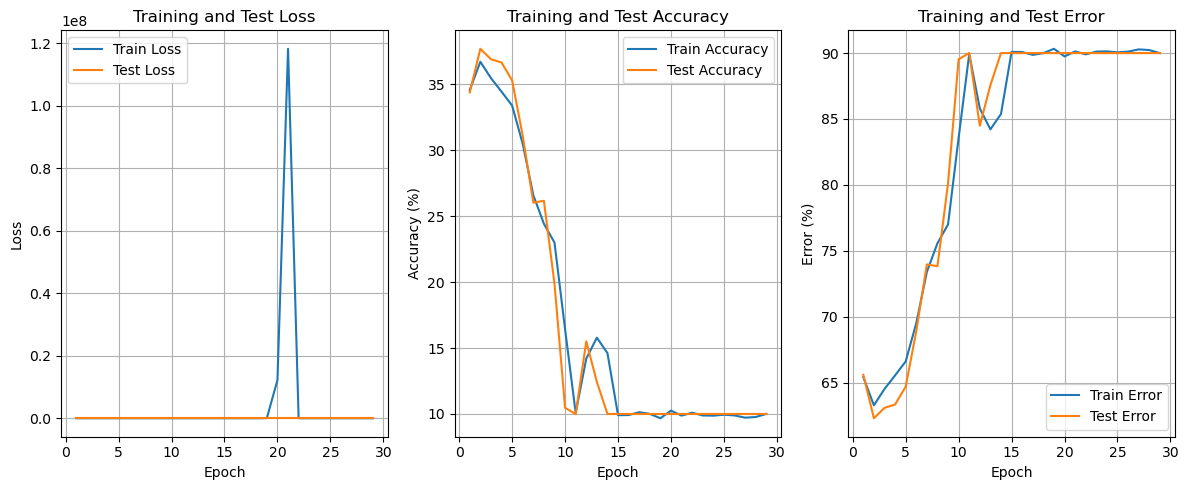

In [12]:
import numpy as np
from plot import metrics_plot

n_epochs = 29
threshold = 90
lr = 0.01
lambda_l1 = 0.001

train_losses, test_losses, train_errs, test_errs, train_accs, test_accs, run_times = modeling(n_epochs=n_epochs,
                                                                                          lr=lr,
                                                                                          lambda_l1=lambda_l1,
                                                                                          threshold=threshold,
                                                                                         )
save_path = f'epoch_scores'
save_performance(save_path,
                 train_losses, test_losses, train_errs, 
                 test_errs, train_accs, test_accs, run_times, n_step=lr,
                 )
actual_nepochs = len(train_losses)
metrics_plot(actual_nepochs, train_losses, test_losses, train_accs, test_accs, train_errs, test_errs)